In [1]:
load_ext cython

In [53]:
%%cython

import numpy as np
cimport numpy as np
from scipy.stats.stats import pearsonr
from scipy.io import loadmat
import sys
from math import exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform


def timecorr_input(filename, gaussian_variance, estimation_range=3, mode = "within"):
    data = np.load(filename)
    activations = data['arr_2']
    
def timecorr(activations, int gaussian_variance, int estimation_range=3, mode = "within"):
    if len(activations.shape)==2:
        return correlation_calculation_single(activations.T, gaussian_variance, estimation_range)
    else:
        # the data file is expected to be of dimensions [subject number, time length, activations length]
        # and converted to dimensions [subject number, activations length, time length]
        activations = np.array(activations)
        activations = np.swapaxes(activations,1,2)
        subject_num, activations_len, time_len = activations.shape
        
        if mode=="within":
            subject_num = len(activations)
            activations_len, time_len= activations[0].shape
            result = np.zeros([subject_num, time_len,(activations_len * (activations_len-1) / 2)])
            for subject in range(subject_num):
                result[subject] = correlation_calculation_single(activations[subject], gaussian_variance, estimation_range)
            return result
        else:
            return ISFC(activations, gaussian_variance, estimation_range)
    
    
def correlation_calculation_single(np.ndarray activations, int gaussian_variance, int estimation_range):
    cdef np.ndarray gaussian_array, covariances, covariances_vector
    cdef np.ndarray activations_shifted, covariance_fragments
    cdef int timepoint, i, half_range
    
    half_range = int((estimation_range-1)/2)
    activations_len, time_len = activations.shape[0], activations.shape[1]
    gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])
    covariances = covariance_fragments = np.zeros([time_len, activations_len, activations_len])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])
    activations_shifted = activations - np.concatenate((np.zeros([activations_len,1]),activations[:,:-1]),1)

    for timepoint in range(half_range,time_len-half_range):
        covariance_fragments[timepoint,:,:] = np.cov(activations_shifted[:,(timepoint-1):(timepoint+2)])        
    covariance_fragments[range(half_range),:,:], covariance_fragments[range(time_len-half_range, time_len),:,:] = covariance_fragments[1,:,:], covariance_fragments[time_len-2,:,:]

    for timepoint in range(time_len):
        coefficients = gaussian_array[(time_len-1-timepoint):(2*time_len-1-timepoint)]
        coefficients = coefficients/np.sum(coefficients)
        coefficients = np.array([np.tile(val,[activations_len,activations_len]) for val in coefficients])
        covariances[timepoint,:,:] = np.sum(np.multiply(coefficients, covariance_fragments),0)

    for i in range(time_len):
        covariances_vector[i] = squareform(covariances[i,:,:],checks=False)
    
    return covariances_vector

    
def ISFC(np.ndarray[double, ndim=3] activations, int gaussian_variance, int estimation_range):
    #cython variable declaration
    cdef int time_len, activations_len, subj_num, timepoint, subject
    cdef double val
    cdef np.ndarray[double, ndim=2] covariances_vector
    cdef np.ndarray[double, ndim=3] activations_shifted, activations_sum, covariances_mean
    cdef np.ndarray[double, ndim=4] covariances, covariance_fragments, coefficients
    cdef np.ndarray gaussian_array,
    
    #assign initial parameters
    subj_num = activations.shape[0]
    activations_len, time_len= activations[0].shape
    covariances = covariance_fragments = np.zeros([subj_num,time_len,activations_len,activations_len])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])    
    coefficients = np.zeros([time_len,time_len,activations_len,activations_len])
    gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])

    for timepoint in range(time_len):
        coefficient = gaussian_array[(time_len-1-timepoint):(2*time_len-1-timepoint)]
        coefficient = coefficient/np.sum(coefficient)
        coefficients[timepoint] = np.swapaxes(np.tile(np.tile(coefficient,[activations_len,1]),[activations_len,1,1]),2,0)
    
    #generate the activation matrix by finding difference between consecutive datapoints
    activations_shifted = activations - np.concatenate((np.zeros([subj_num,activations_len,1]),activations[:,:,:-1]),2)

    #create a matrix that, for each subject, contains the sum of the data for all other subjects
    activations_sum = (np.tile(np.sum(activations_shifted,0),[subj_num,1,1]) - activations_shifted)/(subj_num-1)
    
    #calculate the covariances for each timepoint for each subject
    for subj in range(subj_num):
        #calculate covariance fragments for each timepoint using 3 consecutive timepoints
        for timepoint in range(1,time_len-1):
            covariance_fragments[subj,timepoint,:,:] = np.cov(activations_shifted[subj,:,(timepoint-1):(timepoint+2)],\
                                                            activations_sum[subj,:,(timepoint-1):(timepoint+2)])[:activations_len,activations_len:]
        #the first and last timepoint of the covariance fragments are equal to the second and second to last fragments
        covariance_fragments[subj,0,:,:], covariance_fragments[subj,time_len-1,:,:] = covariance_fragments[subj,1,:,:], covariance_fragments[subj,time_len-2,:,:]

        #multiply the covariance fragments with the gaussian coefficients
        for timepoint in range(time_len):
            covariances[subj, timepoint,:,:] = np.sum(np.multiply(coefficients[timepoint], covariance_fragments[subj]),0)

    #normalize and average the covariance matrix
    covariances_mean = np.mean(0.5*(np.log(1+covariances) - np.log(1-covariances)),0)/2
    covariances_mean =  (np.exp(2*covariances_mean) - 1)/(np.exp(2*covariances_mean) + 1)

    #convert the square covariance matrices into vector form
    for i in range(time_len):
        covariances_vector[i] = squareform(covariances_mean[i,:,:],checks=False)

    return covariances_vector

In [60]:
import numpy as np
from math import sqrt, pi, exp

#parameter initialization
filename = "../../data/BDM_DATA/synthetic_data_validation.npz"
time_len = 1000
activations_len = 5
feature_std = 0.1
gaussian_variance = 20
subject_num=5

#data matrices
feature_maps = np.zeros([time_len,activations_len,activations_len])
covariance, covariance1 = np.zeros([activations_len,activations_len]), np.zeros([activations_len,activations_len])
activations = np.zeros([time_len,time_len,activations_len])
final_activation = np.zeros([time_len,activations_len])
gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])
covariance, covariance1 = np.zeros([activations_len,activations_len]), np.zeros([activations_len,activations_len])

def simplified_activations_generation():
    global covariance, covariance1,final_activation
    feature_map = np.random.normal(0,feature_std,[activations_len,activations_len])
    covariance = np.dot(feature_map,feature_map.T)
    feature_map1 = np.random.normal(0,feature_std,[activations_len,activations_len])
    covariance1 = np.dot(feature_map1,feature_map1.T)
    final_activation[0,:] = initial_activation  = np.random.multivariate_normal(np.zeros(activations_len), covariance)
    for i in range(1, time_len):
        cov_temp = (1000-i)*covariance/1000.0+i*covariance1/1000.0
        final_activation[i, :] = np.random.multivariate_normal(final_activation[(i-1),:],cov_temp)

#     for i in range(1, time_len/2):
#         final_activation[i,:] = np.random.multivariate_normal(final_activation[(i-1),:],covariance)
#     for i in range(time_len/2, time_len):
#         final_activation[i,:] = np.random.multivariate_normal(final_activation[(i-1),:],covariance1)
simplified_activations_generation()
activations = np.tile(final_activation,[subject_num,1,1])
# +np.random.normal(0,0.01,[subject_num,time_len,activations_len])

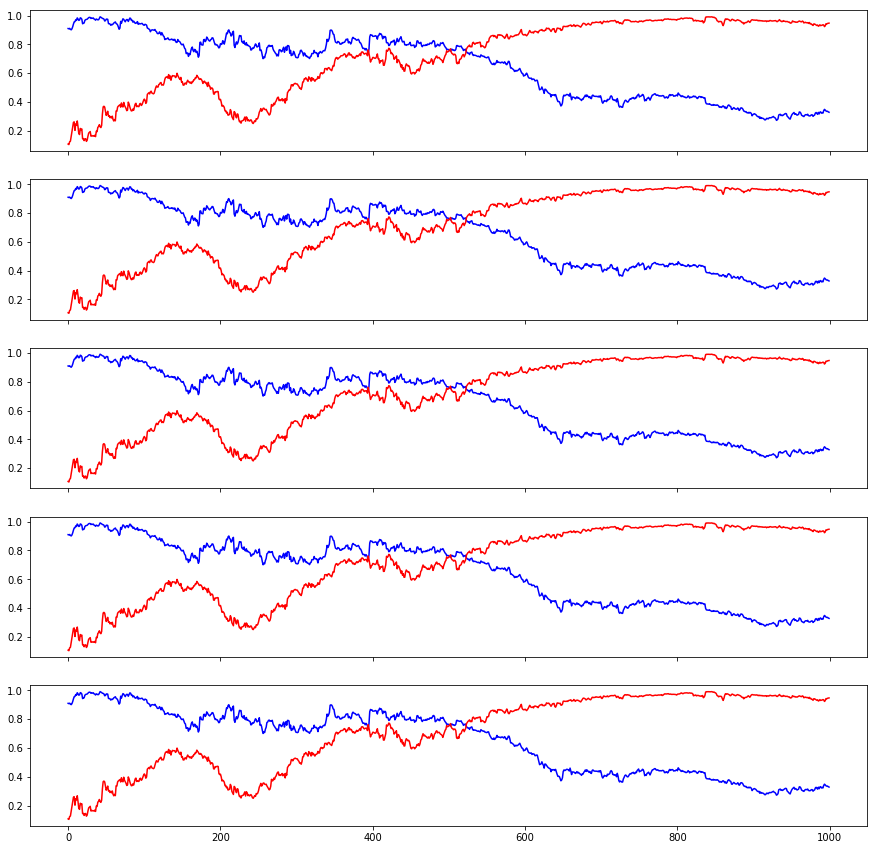

In [61]:
covariances_vectors = timecorr(activations, 1000, 3, "within")
f, axarr = plt.subplots(subject_num, sharex=True, figsize=(15,15))
for subj, covariances_vector in enumerate(covariances_vectors):
    true_covariances_vector = squareform(covariance,checks=False)
    true_covariances_vector1 = squareform(covariance1,checks=False)
    Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
    Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
    axarr[subj].plot(range(time_len),Y,'b-')
    axarr[subj].plot(range(time_len),Y1,'r-')
plt.show()

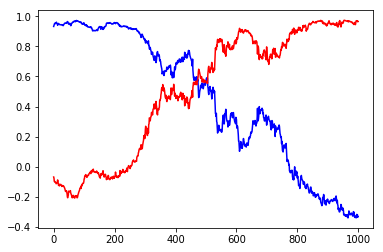

In [41]:
covariances_vector = timecorr(final_activation, 1000, 3, "across")
true_covariances_vector = squareform(covariance,checks=False)
true_covariances_vector1 = squareform(covariance1,checks=False)
Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
plt.plot(range(time_len),Y,'b-')
plt.plot(range(time_len),Y1,'r-')
plt.show()

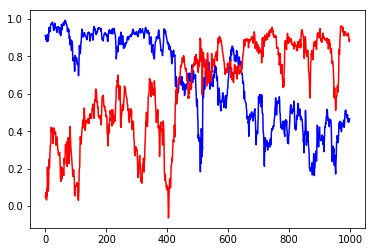

In [33]:
correlation_calculation_single("../synthetic_data_cross.npz", 100)

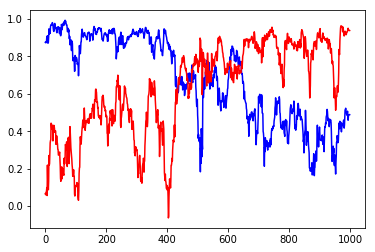

In [30]:
correlation_calculation_single("../synthetic_data_cross.npz", 100, 11)

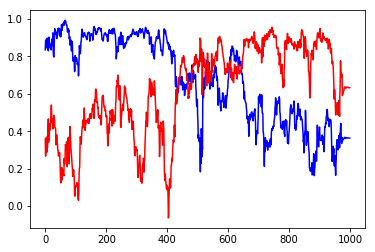

In [31]:
correlation_calculation_single("../synthetic_data_cross.npz", 100, 51)